In [74]:
import pandas as pd
import numpy as np
import requests
import scipy.stats as stats
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import os
import functools
from pylab import rcParams

%matplotlib inline
plt.style.use("ggplot")
sns.set_palette("muted")
rcParams["figure.figsize"] = 15, 10
rcParams["font.size"] = 20

## TASK 1: DATA ACQUISITION AND INTEGRATION

### a) Static Data

In [75]:
DATA_FILE = "WHRData2020.xls"
if not os.path.isfile(DATA_FILE):
    raise Exception("Input file {} does not exist.".format(DATA_FILE))

whr = pd.read_excel(DATA_FILE, sheet_name="Table2.1")

### b) Dynamic Data

For this section I'm going for option 1, the World Bank data indicators.
World Bank data provides a quite comprehensive and easy-to-work-with summary of all indicators it provides at https://data.worldbank.org/indicator

My principle of choosing indicators are:

- Choose indicators that are distributed in different categories, to get a broader picture

- Choose indicators that I believe related to happiness from personal experience, but missing in WHR data

- Choose indicators that I have been curious whether/how they are affecting happiness

The five indicator I'm interested in are:

- **Population (from Health category)**: does the size (in terms of population) of a country affect its residents' happiness? I suspect that people from small countries tend to be happier.

- **Urban Population Percentage (from Urban Development category)**: Does the process of urbanization affect residents' happiness? I have heard opinions from both sides, the ones that think urbanization makes more people happy and the opposite.

- **Unemployment Rate (from Social Protection & Labor category)**: Whether having a job makes a difference for residents' happiness? 

- **Government Expenditure on Education against GDP (from Education category)**: I suspect public funded education improve residents' happiness largely.

- **Forest Area Percentage (from Environment category)**: Personally I find living in forest area much joyful. Is this actually the case across the world?

Of course the availability of indicators also matters. Luckily after a quick check on World Bank's summary for each indicator (e.g. https://data.worldbank.org/indicator/AG.LND.FRST.ZS?view=chart for Forest Area Percentage), availability is not a problem.

The next step is to figure out the API call structure to get certain indicators' data for all countries during certain years (in particular, the years the WHR data covers). This is described in the [documentation](https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures), except for where to look up the indicator codes. I then did a in-site search and found [this article](https://datahelpdesk.worldbank.org/knowledgebase/articles/201175-how-does-the-world-bank-code-its-indicators), with a linked Excel file containing all indicator codes. Latter, I also discovered that the indicator code is shown in the "Details" pop-up window for each indicator, which I'd argue could be designed more beginner friendly.



In [77]:
def get_all_country_data_for_years(indicator_code, start_year, end_year):
    TEMPLATE = "https://api.worldbank.org/v2/country/all/indicator/%s?format=json&date=%s:%s&per_page=%s"
    URL = TEMPLATE % (indicator_code, start_year, end_year, 5000)
    result = json.loads(requests.get(URL).content)
    if result[0]["per_page"] < result[0]["total"]:
        URL = TEMPLATE % (indicator_code, start_year,
                          end_year, result[0]["total"])
        result = json.loads(requests.get(URL).content)
    return result


indicators = {
    "Population": "SP.POP.TOTL",
    "Urban Population Percentage": "SP.URB.TOTL.IN.ZS",
    "Unemployment Rate": "SL.UEM.TOTL.ZS",
    "Government Expenditure on Education against GDP": "SE.XPD.TOTL.GD.ZS",
    "Forest Area Percentage": "AG.LND.FRST.ZS"}

start_year, end_year = min(whr["year"]), max(whr["year"])

dfs_to_integrate = []
for k, v in indicators.items():
    df = pd.DataFrame.from_dict(
        get_all_country_data_for_years(v, start_year, end_year)[1])
    df = df[["country", "date", "value"]].rename(
        columns={"country": "Country name", "date": "year", "value": k})
    df["Country name"] = df[["Country name"]].applymap(lambda x: x['value'])
    df["year"] = df["year"].astype(int)
    dfs_to_integrate.append(df)

For each indicator, we only keep three columns: country name, year, and value (which is renamed to indicator title). 

### c) Integration

Before integration, we first check that there are no duplicated (country, year) records inside original WHR data itself and each of the 5 indicator dataframes:

In [78]:
for df in [whr] + dfs_to_integrate:
    assert not df.duplicated(["Country name", "year"]).any()

Next, we need to consolidate the country names, so that the merge will not wrongly drop indicator data with different country names but actually referring to the same countries. This turns out taking more effort than expected.

I considered manually comparing (gave up in 3 seconds), libs like `pycountry` (which does not work very well, e.g. it cannot even tell that Hong Kong S.A.R of China is the same as Hong Kong), and country alias mapping resources I can find online... none of which is satisfactory. Eventually I've settled for this solution with Bing Map, which takes care of fuzzy address matching pretty well:

1. Find country names in WHR that are missing in some indicator data. Use Bing Map's API to build a mapping from Bing's standard country name to these WHR country names. (e.g. standard name Congo (DRC) is mapped to Congo (Kinshasa) used in WHR)

2. Find country names in indicator data that are missing in WHR. Use Bing Map's API to build a mapping from indicator data's country names to Bing's standard country name. (e.g. country name Congo, Dem. Rep. in indicator data is mapped to standard name Congo (DRC))

3. With the two mappings we've built, we update each indicator country names to the name used in WHR.

4. During the process, we keep track of all the names that cannot be handled by Bing Map, and do the correct mapping manually. There should be only few of them.

**This solution requires a Bing Map API key, which you can get from [here](https://www.microsoft.com/en-us/maps/create-a-bing-maps-key/#basic). Alternatively, for the ease of marking, the API call results is reproduced in later cell. Just skip running the cells that needs API keys.**

First, we build the mapping from standard country names to WHR country names.

In [79]:
whr_countries = set(whr["Country name"])
df_countries_set = functools.reduce(
    set.union, [set(df["Country name"]) for df in dfs_to_integrate])

In [ ]:
# This cell needs Bing Map API key to run
stdname_to_whrname = dict()
man_check = {k: set() for k in ["whr"] + [df.columns[2]
                                          for df in dfs_to_integrate]}

API_KEY = "YouApiKey"
BING_MAP_TEMPLATE = "http://dev.virtualearth.net/REST/v1/Locations/%s?key=%s"


def clean_country_name(name):
    """Clean name to a form that Bing knows better."""
    return name.replace("'", "").replace(".", "").replace(",", "").replace("&", "and").replace("Rep", "Republic").replace("Dem", "Democratic")


def get_bingmap_std_name(name):
    try:
        result = json.loads(requests.get(BING_MAP_TEMPLATE %
                                         (clean_country_name(name), API_KEY)).content)
        return result["resourceSets"][0]["resources"][0]["name"]
    except:
        return None


for country in whr_countries - df_countries_set:
    stdname = get_bingmap_std_name(country)
    if stdname:
        stdname_to_whrname[stdname] = country
    else:
        man_check["whr"].add(country)

if man_check["whr"]:
    print("These countries in WHR cannot be found via Bing Map and need to be manually checked.")
    print(man_check["whr"])

print(stdname_to_whrname)

In [80]:
# results from previous cell's API calls for ease of marking
man_check = {'whr': {'Palestinian Territories'},
             'Population': set(),
             'Urban Population Percentage': set(),
             'Unemployment Rate': set(),
             'Government Expenditure on Education against GDP': set(),
             'Forest Area Percentage': set()}
stdname_to_whrname = {'Cyprus': 'North Cyprus', 'Russia': 'Russia', 'Republic of the Congo': 'Congo (Brazzaville)', 'China': 'Taiwan Province of China', 'Congo (DRC)': 'Congo (Kinshasa)', 'Yemen': 'Yemen', 'Slovakia': 'Slovakia', 'The Gambia': 'Gambia', 'Eswatini': 'Swaziland', 'Kyrgyzstan': 'Kyrgyzstan',
                      'Region, KY': 'Somaliland region', "Côte d'Ivoire": 'Ivory Coast', 'South Korea': 'South Korea', 'Iran': 'Iran', 'Egypt': 'Egypt', 'Syria': 'Syria', 'Venezuela': 'Venezuela', 'North Macedonia': 'Macedonia', 'Hong Kong SAR': 'Hong Kong S.A.R. of China', 'Laos': 'Laos'}

As shown in the code above, there's only one country in WHR that Bing Map does not recognize, which is Palestinian Territories. There are complex historical and political reasons behind the [variance of the name](https://en.wikipedia.org/wiki/Palestinian_territories). Different names are used by different data sources, so it has to be handled manually.

[World Bank's website](https://data.worldbank.org/country/west-bank-and-gaza?view=chart) shows that its indicators use the name West Bank and Gaza for the same country/region. It's also verified by inspecting the indicator data returned by the World Bank API.

So we build the manual mapping:

In [81]:
man_mapping = {"West Bank and Gaza": 'Palestinian Territories'}

Next, we build the mapping from indicator country names to standard names:

In [ ]:
# This cell needs Bing Map API key to run
dfname_to_stdname = dict()
for df in dfs_to_integrate:
    df_countries_set = set(df["Country name"])
    for country in df_countries_set - whr_countries - set(man_mapping.keys()):
        if country in dfname_to_stdname:
            continue
        if any(country in v for v in man_check.values()):
            man_check[df.columns[2]].add(country)
            continue
        stdname = get_bingmap_std_name(country)
        if stdname:
            dfname_to_stdname[country] = stdname
        else:
            man_check[df.columns[2]].add(country)

    if man_check[df.columns[2]]:
        print("These countries in %s cannot be found via Bing Map and need to be manually checked." %
              df.columns[2])
        print(man_check[df.columns[2]])

print(dfname_to_stdname)

In [82]:
# results from previous cell's API calls for ease of marking
man_check["Population"] = {'Fragile and conflict affected situations',
                           'IBRD only',
                           'Least developed countries: UN classification',
                           'OECD members',
                           'World'}

man_check["Urban Population Percentage"] = {'Fragile and conflict affected situations',
                                            'IBRD only',
                                            'Least developed countries: UN classification',
                                            'OECD members',
                                            'World'}

man_check["Unemployment Rate"] = {'Fragile and conflict affected situations',
                                  'IBRD only',
                                  'Least developed countries: UN classification',
                                  'OECD members',
                                  'World'}

man_check["Government Expenditure on Education against GDP"] = {'Fragile and conflict affected situations',
                                                                'IBRD only',
                                                                'Least developed countries: UN classification',
                                                                'OECD members',
                                                                'World'}

man_check["Forest Area Percentage"] = {'Fragile and conflict affected situations',
                                       'IBRD only',
                                       'Least developed countries: UN classification',
                                       'OECD members',
                                       'World'}

dfname_to_stdname = {'Pre-demographic dividend': 'Pré, Vienne, France', 'Samoa': 'Samoa', 'Bermuda': 'Bermuda', 'Eritrea': 'Eritrea', 'Sub-Saharan Africa (excluding high income)': 'Sahara', 'Egypt, Arab Rep.': 'Republic Street, Markaz Edko, Beheira, Egypt', 'Europe & Central Asia': 'Andorra', 'Gambia, The': 'The Gambia', 'American Samoa': 'American Samoa', 'Grenada': 'Grenada', 'Marshall Islands': 'Marshall Islands', 'Russian Federation': 'Russia', 'Early-demographic dividend': 'Dividend, UT', 'Syrian Arab Republic': 'Syria', 'North America': 'North America', 'Euro area': 'Ste.-Marie-aux-Mines, Haut-Rhin, France', 'Pacific island small states': 'Iceland', 'Liechtenstein': 'Liechtenstein', 'Equatorial Guinea': 'Equatorial Guinea', 'Kiribati': 'Kiribati', 'Low income': 'Low Island, Australia', 'IDA total': 'Idaho', 'IDA only': 'Idaho', 'Lower middle income': 'Middle, IA', 'Seychelles': 'Seychelles', 'St. Vincent and the Grenadines': 'St Vincent and the Grenadines', 'Sub-Saharan Africa': 'Sahara', 'Palau': 'Palau', 'Heavily indebted poor countries (HIPC)': 'Poor, TN', 'European Union': 'Union Parish', 'Aruba': 'Aruba', 'High income': 'High Island, MI', 'Cayman Islands': 'Cayman Islands', 'Micronesia, Fed. Sts.': 'Federated States of Micronesia', 'Latin America & the Caribbean (IDA & IBRD countries)': 'United States', 'Congo, Rep.': 'Republic of the Congo', 'Gibraltar': 'Gibraltar', 'St. Kitts and Nevis': 'St Kitts and Nevis', 'Andorra': 'Andorra', 'Puerto Rico': 'Puerto Rico', 'Curacao': 'Curacao', 'Other small states': 'States, TX', 'Post-demographic dividend': 'Dividend, UT', 'Turks and Caicos Islands': 'Turks and Caicos Islands', 'Antigua and Barbuda': 'Antigua and Barbuda', 'North Macedonia': 'North Macedonia', 'Europe & Central Asia (excluding high income)': 'Andorra', 'IDA & IBRD total': 'Idaho', 'Tonga': 'Tonga', 'Middle income': 'Middle, IA', 'Small states': 'States, TX', 'Yemen, Rep.': 'Yemen', 'East Asia & Pacific (IDA & IBRD countries)': 'Asia', "Cote d'Ivoire": "Côte d'Ivoire", 'East Asia & Pacific (excluding high income)': 'Asia', 'Korea, Rep.': 'South Korea', 'San Marino': 'San Marino',
                     'Sint Maarten (Dutch part)': 'St Marten', 'Bahamas, The': 'The Bahamas', 'Macao SAR, China': 'Macao SAR', 'Slovak Republic': 'Slovakia', 'Europe & Central Asia (IDA & IBRD countries)': 'Andorra', 'Vanuatu': 'Vanuatu', 'Iran, Islamic Rep.': 'Iran', 'Tuvalu': 'Tuvalu', 'East Asia & Pacific': 'Asia', 'Greenland': 'Greenland', 'South Asia': 'South Island, India', 'Caribbean small states': 'Caribbean', 'Monaco': 'Monaco', 'Dominica': 'Dominica', 'Hong Kong SAR, China': 'Hong Kong SAR', 'Virgin Islands (U.S.)': 'Virgin Islands Ct, Pleasanton, CA 94588, United States', 'Papua New Guinea': 'Papua New Guinea', 'Solomon Islands': 'Solomon Islands', 'Kyrgyz Republic': 'Kyrgyzstan', 'Sub-Saharan Africa (IDA & IBRD countries)': 'Ida, South Africa', 'New Caledonia': 'New Caledonia', 'IDA blend': 'Idaho', 'Congo, Dem. Rep.': 'Congo (DRC)', 'French Polynesia': 'French Polynesia', 'Middle East & North Africa (excluding high income)': 'Africa', 'Northern Mariana Islands': 'Northern Mariana Islands', 'Timor-Leste': 'Timor-Leste', 'Brunei Darussalam': 'Brunei', 'Latin America & Caribbean': 'United States', 'Cabo Verde': 'Cape Verde', 'Faroe Islands': 'Faroe Islands', 'Isle of Man': 'Isle of Man', 'Sao Tome and Principe': 'São Tomé and Príncipe', 'Venezuela, RB': 'Avenida Venezuela, Iribarren, Venezuela', 'South Asia (IDA & IBRD)': 'Ida, Philippines', 'Middle East & North Africa (IDA & IBRD countries)': 'Ida, South Africa', 'St. Lucia': 'St Lucia', 'Guinea-Bissau': 'Guinea-Bissau', 'Korea, Dem. People’s Rep.': 'North Korea', 'Lao PDR': 'Laos', 'Arab World': 'Arab, AL', 'British Virgin Islands': 'British Virgin Islands', 'Middle East & North Africa': 'Africa', 'Upper middle income': 'Middle, IA', 'Fiji': 'Fiji', 'Latin America & Caribbean (excluding high income)': 'United States', 'St. Martin (French part)': 'St Martin', 'Not classified': 'Not, Lot-et-Garonne, France', 'Central Europe and the Baltics': 'Andorra', 'Late-demographic dividend': 'Dividend, UT', 'Low & middle income': 'Middle, IA', 'Barbados': 'Barbados', 'Eswatini': 'Eswatini', 'Nauru': 'Nauru', 'Channel Islands': 'Jersey', 'Guam': 'Guam'}

Note that some Bing Map is not perfect, some mappings are obviously ridiculous. For example, Bing guesses "Pre-demographic dividend" the same as "Pré, Vienne, France", probably due to the common substring "Pre". Yet such cases will not cause us trouble, as they are taken care of by code below and the left merge with one-one validation later.

Now we update the country names in indicator data to be the same as in WHR:

In [83]:
def map_dfname_to_whrname(name):
    if name in whr_countries:
        return name
    elif name in man_mapping:
        return man_mapping[name]
    elif name in dfname_to_stdname:
        stdname = dfname_to_stdname[name]
        if stdname in stdname_to_whrname:
            return stdname_to_whrname[stdname]
    return name


for df in dfs_to_integrate:
    df["Country name"] = df["Country name"].apply(map_dfname_to_whrname)

Effectively, the code above updates the country names in indicator data to the names used in WHR, with the following mapping:

- Iran, Islamic Rep. -> Iran
- Syrian Arab Republic -> Syria
- Congo, Rep. -> Congo (Brazzaville)
- North Macedonia -> Macedonia
- Kyrgyz Republic -> Kyrgyzstan
- Russian Federation -> Russia
- Gambia, The -> Gambia
- Yemen, Rep. -> Yemen
- Eswatini -> Swaziland
- Congo, Dem. Rep. -> Congo (Kinshasa)
- Korea, Rep. -> South Korea
- Slovak Republic -> Slovakia
- Hong Kong SAR, China -> Hong Kong S.A.R. of China
- Lao PDR -> Laos
- Cote d'Ivoire -> Ivory Coast
- West Bank and Gaza -> Palestinian Territories

Finally, we can integrate the indicator data to original WHR:

In [84]:
for df in dfs_to_integrate:
    whr = whr.merge(df, on=["Country name", "year"],
                    how="left", validate="one_to_one")
whr

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,...,"Most people can be trusted, WVS round 1989-1993","Most people can be trusted, WVS round 1994-1998","Most people can be trusted, WVS round 1999-2004","Most people can be trusted, WVS round 2005-2009","Most people can be trusted, WVS round 2010-2014",Population,Urban Population Percentage,Unemployment Rate,Government Expenditure on Education against GDP,Forest Area Percentage
0,Afghanistan,2008,3.723590,7.144916,0.450662,50.799999,0.718114,0.178993,0.881686,0.517637,...,NaN,NaN,NaN,NaN,NaN,27722276.0,23.320,10.985,NaN,2.067825
1,Afghanistan,2009,4.401778,7.314788,0.552308,51.200001,0.678896,0.201228,0.850035,0.583926,...,NaN,NaN,NaN,NaN,NaN,28394813.0,23.528,11.387,NaN,2.067825
2,Afghanistan,2010,4.758381,7.421525,0.539075,51.599998,0.600127,0.131578,0.706766,0.618265,...,NaN,NaN,NaN,NaN,NaN,29185507.0,23.737,11.484,3.47945,2.067825
3,Afghanistan,2011,3.831719,7.394349,0.521104,51.919998,0.495901,0.173452,0.731109,0.611387,...,NaN,NaN,NaN,NaN,NaN,30117413.0,23.948,11.488,3.46201,2.067825
4,Afghanistan,2012,3.782938,7.480296,0.520637,52.240002,0.530935,0.246943,0.775620,0.710385,...,NaN,NaN,NaN,NaN,NaN,31161376.0,24.160,11.508,2.60420,2.067825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,Zimbabwe,2015,3.703191,7.827643,0.735800,53.799999,0.667193,-0.117035,0.810457,0.715079,...,NaN,NaN,0.116683,NaN,0.082942,13814629.0,32.385,5.302,NaN,36.350006
1844,Zimbabwe,2016,3.735400,7.819675,0.768425,54.400002,0.732971,-0.088488,0.723612,0.737636,...,NaN,NaN,0.116683,NaN,0.082942,14030390.0,32.296,5.253,NaN,35.542457
1845,Zimbabwe,2017,3.638300,7.851042,0.754147,55.000000,0.752826,-0.091540,0.751208,0.806428,...,NaN,NaN,0.116683,NaN,0.082942,14236745.0,32.237,5.168,5.62184,NaN
1846,Zimbabwe,2018,3.616480,7.896704,0.775388,55.599998,0.762675,-0.063282,0.844209,0.710119,...,NaN,NaN,0.116683,NaN,0.082942,14439018.0,32.209,5.087,4.60449,NaN


## Task 2: DATA CLEANING AND EXPLORATORY DATA ANALYSIS (EDA)

### a) EDA – data quality inspection


First, there are some features in WHR that are meta-data, meaning they are describing data themselves: 
- Standard deviation of ladder by country-year
- Standard deviation/Mean of ladder by country-year

These features will not help us explain what affects a country's happiness score and should be removed.

In [85]:
whr.drop(columns=["Standard deviation of ladder by country-year",
                  "Standard deviation/Mean of ladder by country-year"], inplace=True)

We then check if there are any duplicated rows and columns in the merged data, and remove the redundant rows/columns if necessary. There is no duplication in our case.

In [86]:
# check duplicated rows, there should be no duplicates since we have checked already before integration:
assert not whr.duplicated(["Country name", "year"]).any()

# check if duplicated columns:
assert not whr.T.duplicated().any()  # no duplication in this case

We also need to discard the rows and columns that have too many missing values to be meaningful. Here we define the threshold to be 50% non-missing values for columns, and 20% non-missing values for rows.

In [87]:
whr.dropna(axis=1, thresh=len(whr.index)//2, inplace=True)
whr.dropna(axis=0, thresh=len(whr.columns)*4//5, inplace=True)
whr.to_csv("cleaned.csv")

### b) EDA – the search for good predictors

First we need to aggregate data from different years for each country. This is because we are not doing time series analysis for this assignment, but using features describing a country to predict the the country happiness score.

In [88]:
whr_ave = whr.drop(["year"], axis=1).groupby("Country name").agg("mean")

whr_ave.columns = ["life", "log_gdp_pc", "social_support", "health", "freedom", "generosity", "perception_corruption", "p_affect", "n_affect",
                   "gov_confidence", "democratic", "deliver", "gini", "gini_gallup", "population", "urban_pop_percent", "unemployment_percent", "govern_edu_against_gdp", "forest_percent"]
whr_ave

,life,log_gdp_pc,social_support,health,freedom,generosity,perception_corruption,p_affect,n_affect,gov_confidence,democratic,deliver,gini,gini_gallup,population,urban_pop_percent,unemployment_percent,govern_edu_against_gdp,forest_percent
Country name,,,,,,,,,,,,,,,,,,,
Afghanistan,3.705495,7.420716,0.516270,52.254545,0.529317,0.097309,0.835959,0.566623,0.310703,0.397190,-1.895243,-1.473486,NaN,0.376170,3.231703e+07,24.383727,11.343182,3.529796,2.067825
Albania,4.990211,9.259583,0.719602,67.254545,0.644161,-0.089628,0.863277,0.649053,0.304687,0.412927,0.116105,-0.236362,0.303250,0.489315,2.899726e+06,55.189545,14.757182,3.382367,28.270154
Algeria,5.481872,9.509423,0.803636,65.174286,0.545794,-0.195015,0.680923,0.612277,0.270041,NaN,-1.031371,-0.782020,0.276000,0.516551,3.901650e+07,70.150286,10.739571,NaN,0.813590
Angola,4.420299,8.799585,0.737973,53.550000,0.455957,-0.081353,0.867018,0.613339,0.351173,0.397389,-0.743011,-1.180481,0.473500,0.514382,2.557154e+07,61.632250,7.368000,NaN,46.657576
Argentina,6.358951,9.832404,0.905605,67.715385,0.760258,-0.151323,0.844901,0.839406,0.276827,0.389876,0.213170,-0.441130,0.460706,0.355052,4.180419e+07,91.086308,8.061692,5.183693,10.347709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,6.187020,9.488891,0.916393,65.871111,0.648087,-0.180875,0.811978,0.811533,0.238164,0.371382,-1.048676,-1.523057,0.497167,0.358674,NaN,NaN,NaN,NaN,NaN
Vietnam,5.303290,8.470863,0.827595,66.766667,0.875556,0.016658,0.784404,0.636681,0.208255,0.848363,-0.621222,-0.423794,0.362750,0.441114,8.952823e+07,31.526083,1.862500,4.919631,45.741871
Yemen,3.886234,8.150122,0.727963,54.627273,0.619777,-0.139630,0.828157,0.529471,0.300866,0.394785,-1.973465,-1.261815,0.357000,0.420928,2.510953e+07,33.536000,13.065455,NaN,1.039832


Although `pandas.DataFrame.corr()` gives us the correlation between each columns, it provides no information regarding the p-value of the correlation. Hence, we calculate the correlation with `pearsonr` and only keep those with p-value smaller than 0.05.

In [89]:
cors = {}
for col in whr_ave.columns[1:]:
    pair_df = whr_ave.loc[:, ["life", col]].dropna(axis=0)
    cor, pvalue = pearsonr(pair_df.iloc[:, 0], pair_df.iloc[:, 1])
    if (pvalue < 0.05):
        cors[col] = cor
cors

{'log_gdp_pc': 0.8212365235425529,
 'social_support': 0.7661581612907314,
 'health': 0.7969392138200475,
 'freedom': 0.5759629267705735,
 'generosity': 0.22009982227508904,
 'perception_corruption': -0.44494224828740037,
 'p_affect': 0.5784215915525432,
 'n_affect': -0.34514311480498394,
 'democratic': 0.6587640196244158,
 'deliver': 0.7470149721695627,
 'gini': -0.27617479728948113,
 'gini_gallup': -0.42558871329683245,
 'urban_pop_percent': 0.7066496928182883,
 'govern_edu_against_gdp': 0.4558837408553419}

The correlations' absolute value between target and other 14 features range between about 0.22 to 0.82 (with p-value smaller than 0.05). We consider all these features worthy candidate predictors for our multiple linear regression model. One thing we need to keep in mind is that the multicollinearity is not considered at this stage. This means that the features we get here may contain duplicated information, making some of them redundant in our final model. This will be addressed in stepwise model selection.

Before we move on to actually build the model, we want to check if the assumptions for linear models (linearity, homoscedasticity, normally distributed residuals) are met. In particular, at this stage, we check if the relationship between target and each variable is linear. 

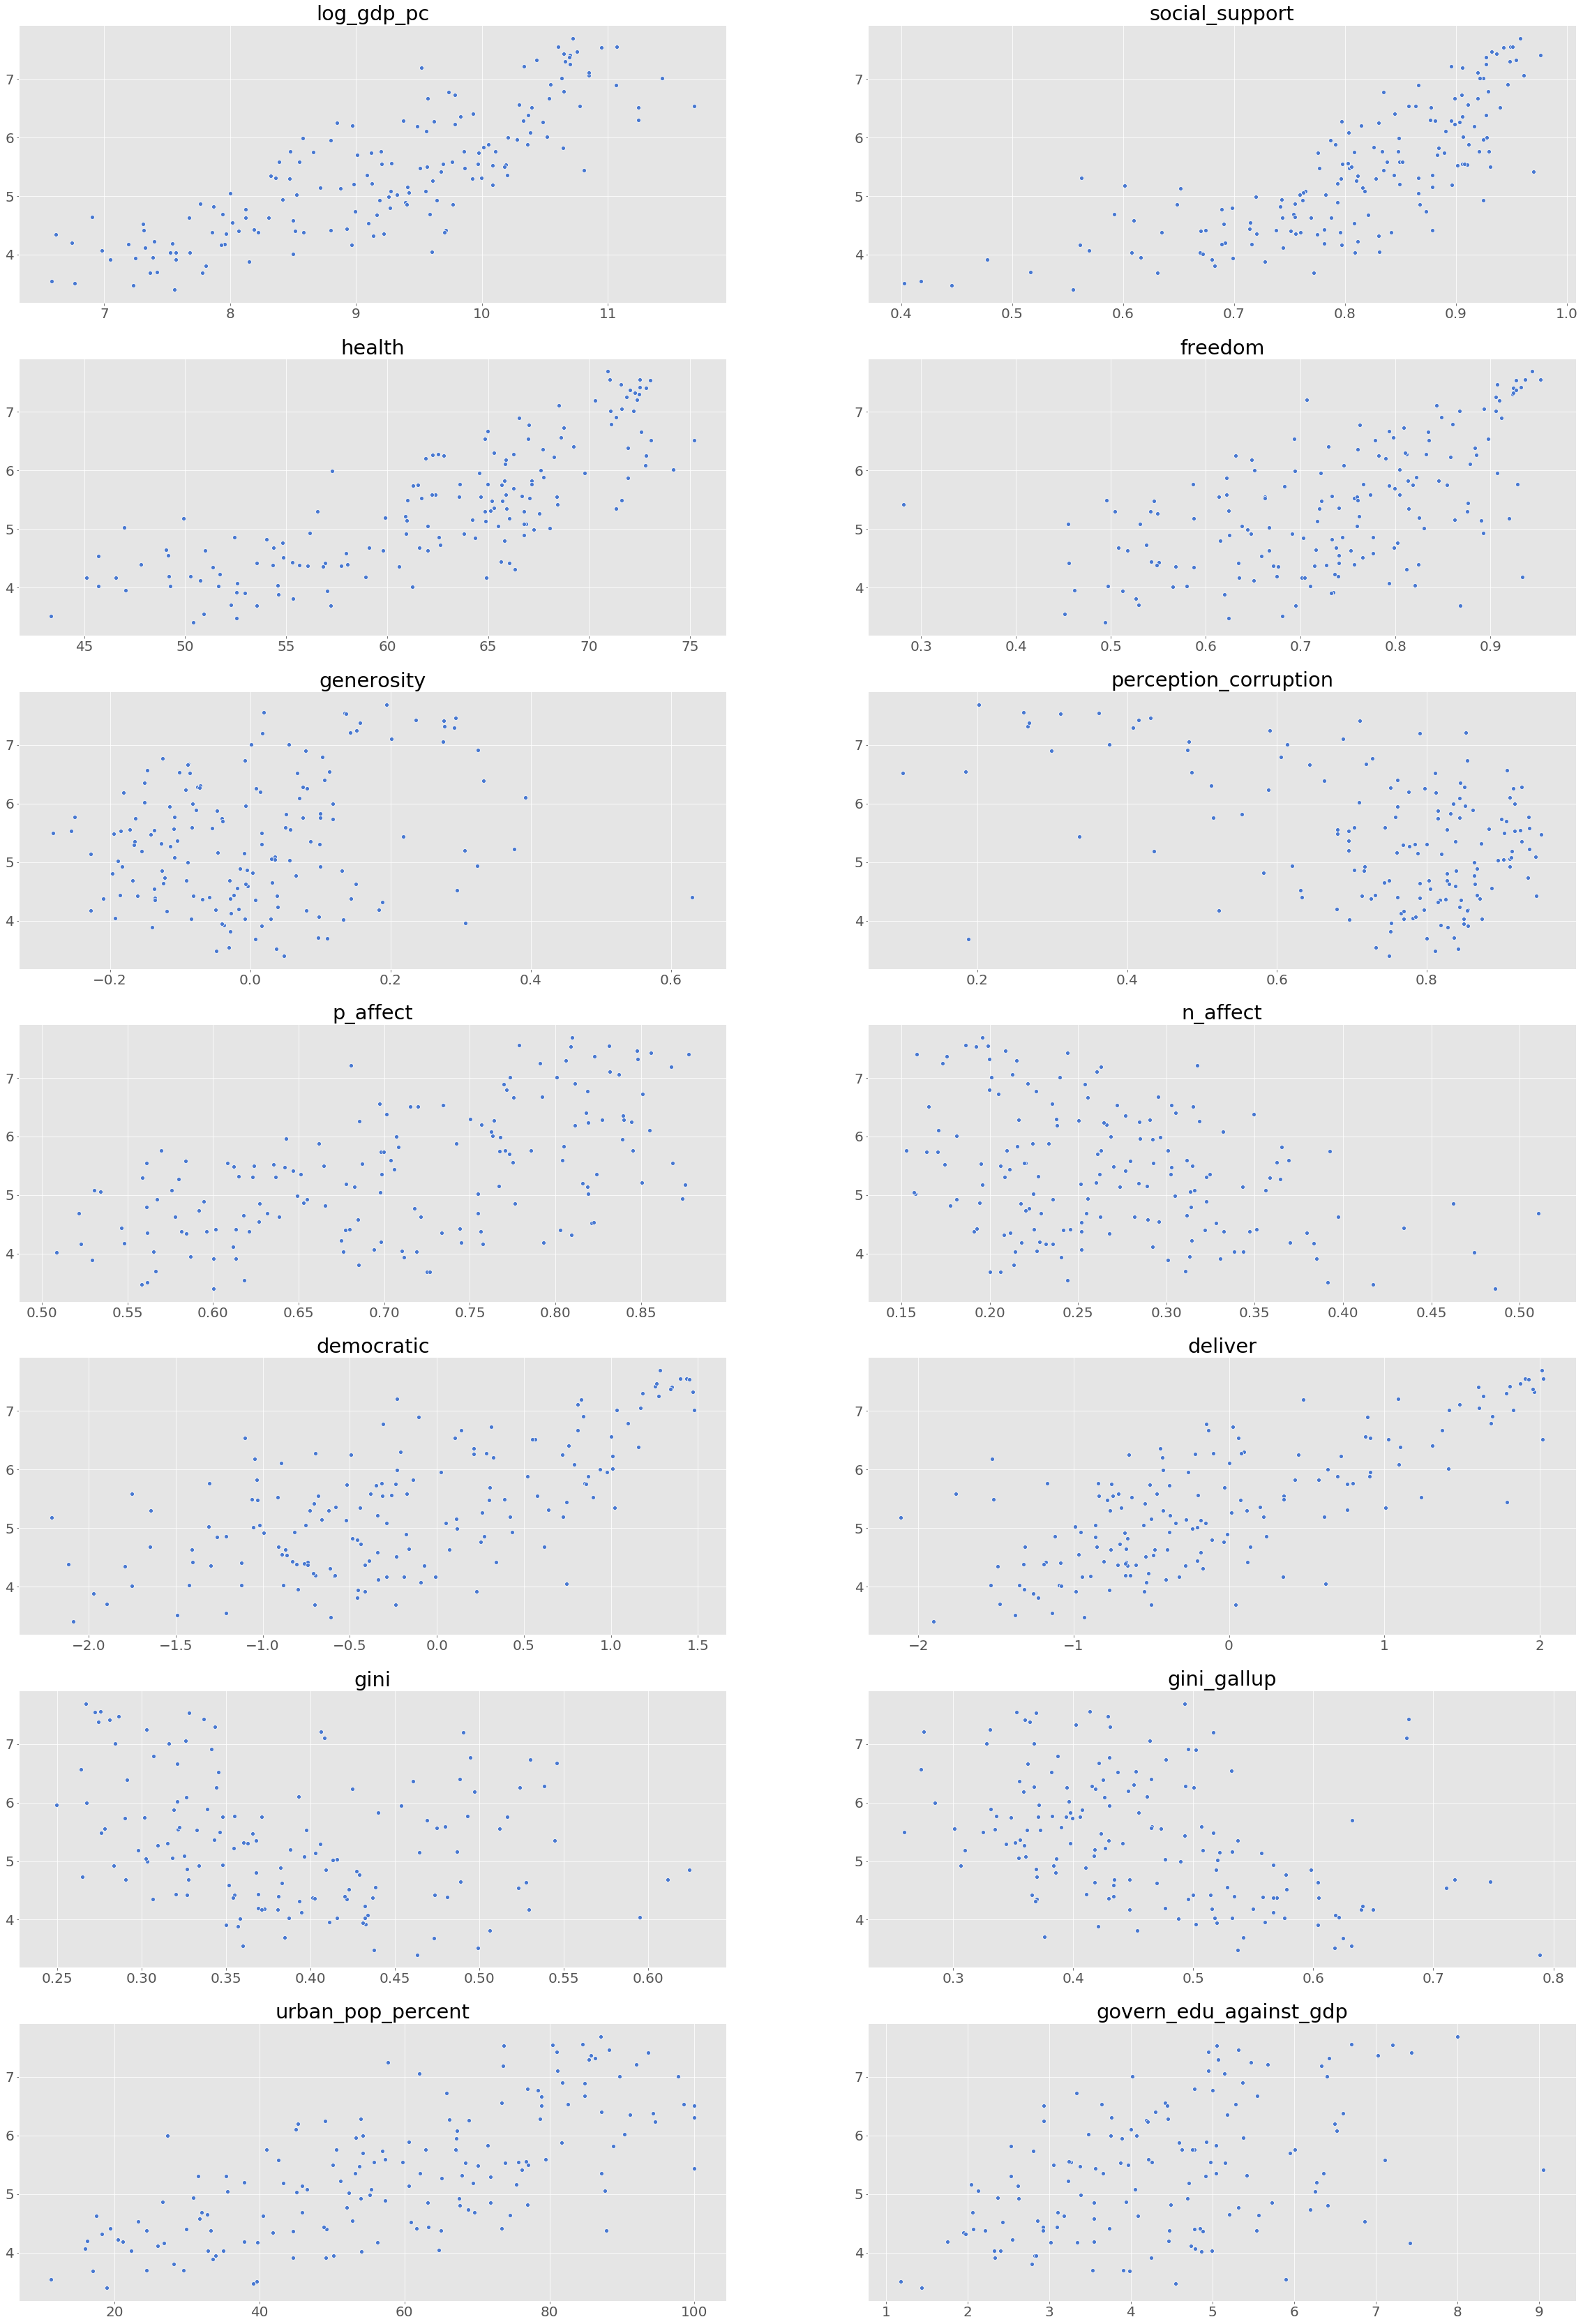

In [90]:
features = list(cors.keys())
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(40, 60))
for i in range(len(features)):
    sns.scatterplot(data=whr_ave, y="life", x=features[i], ax=axes[i//2, i % 2]).set(
        title=features[i], xlabel="", ylabel="")

From the plots above, we do not spot any strong curvy pattern. Therefore it's safe to move on.

## TASK 3: MODELLING

The goal here is to build a model that helps predict a country's happiness score based on some other features describing the country. This makes the model useful for government making decisions in order to gain its residents' happiness. This rules out features that, while might be correlated to the target, not meaningful in reality. In fact, in the data cleaning stage, we have removed the meta-data features such as "Standard deviation of ladder by country-year", etc. This also rules out the "year" feature, simply because it is not helping achieve our goal: a government has no control over what year it is.

Another principle for building our model is to be balanced between predictive power and simplicity. In linear regression, we can always throw in as many features as possible to get a more (or same, but never less) powerful model, but that's not desired, as it would lead to over complex model. Instead we use techniques like nested model F-test to select only features that are bringing significant predictive power. In our case, we will use stepwise double-direction feature selection method to find the (heuristically) best balanced model. 

The code below works like this, given response variable, explanatory variables, and data:
1. Start with null model, which is the model that only uses intercept.
2. For each variable that is not included in the model yet, try adding it, calculating its p-value, and eventually add the one with smallest p-value if the p-value is significant.
3. Try dropping variables from current model that does not have significant p-value one-by-one (as p value changes with each variable added/dropped), until all variables remain do have significant p.
4. Repeat 2 and 3, until there is no variable with significant p-value to add to the model in step 2.

Note that stepwise feature selection also handles the aforementioned multicollinearity problem.

In [91]:
def backwards_regression(model, df):
    while len(model.params) > 1:
        sorted_ps = model.pvalues.sort_values(
            ascending=False).drop('Intercept')
        print(sorted_ps)
        if (sorted_ps[0]) > 0.05:
            print("Old formula:", model.model.formula)
            print(
                'Dropped: ' + sorted_ps.index[0] + ' with p-value ' + str(round(sorted_ps[0], 3)))
            model = smf.ols(formula=model.model.formula.replace(
                "+"+sorted_ps.index[0], ""), data=df).fit()
            print("New formula:", model.model.formula)
            print(str(len(model.params)-1) + ' var model AIC: ' +
                  str(model.aic) + ', adj Rsq: ' + str(model.rsquared_adj))
        else:
            return model


def onestep_forwards_regression(model, exp_vars, df):
    new_vars = set(exp_vars) - set(model.params.drop("Intercept").index)
    if not new_vars:
        return model, False
    pvalues = pd.Series(dtype="float64")
    models = {}
    for var in new_vars:
        m = smf.ols(formula=model.model.formula + "+" + var, data=df).fit()
        pvalues[var] = m.pvalues[var]
        models[var] = m
    minid, minp = pvalues.idxmin(), pvalues.min()
    if minp > 0.05:
        return model, False
    else:
        print("Old formula:", model.model.formula)
        model = models[minid]
        print('Added: ' + minid + ' with p-value ' + str(round(minp, 3)))
        print("New formula:", model.model.formula)
        print(str(len(model.params)-1) + ' var model AIC: ' +
              str(model.aic) + ', adj Rsq: ' + str(model.rsquared_adj))
        return model, True


def double_direction_stepwise_regression(response_var, exp_vars, df):
    null_model = smf.ols(formula=response_var+"~1", data=df).fit()
    print("Built null_model")
    new_model, modified = onestep_forwards_regression(null_model, exp_vars, df)
    while modified:
        new_model, modified = onestep_forwards_regression(
            backwards_regression(new_model, df), exp_vars, df)
    return new_model


mlr_model = double_direction_stepwise_regression(
    "life", features, whr_ave.copy())
mlr_model.summary()

Built null_model
Old formula: life~1
Added: log_gdp_pc with p-value 0.0
New formula: life~1+log_gdp_pc
1 var model AIC: 300.7643094356096, adj Rsq: 0.6723688543572219
log_gdp_pc    2.427290e-40
dtype: float64
Old formula: life~1+log_gdp_pc
Added: p_affect with p-value 0.0
New formula: life~1+log_gdp_pc+p_affect
2 var model AIC: 239.99029402466576, adj Rsq: 0.777283413415374
p_affect      4.640273e-15
log_gdp_pc    3.805765e-39
dtype: float64
Old formula: life~1+log_gdp_pc+p_affect
Added: health with p-value 0.0
New formula: life~1+log_gdp_pc+p_affect+health
3 var model AIC: 213.20983987370704, adj Rsq: 0.8118826207967965
health        1.855195e-06
log_gdp_pc    3.007447e-11
p_affect      3.678163e-15
dtype: float64
Old formula: life~1+log_gdp_pc+p_affect+health
Added: govern_edu_against_gdp with p-value 0.0
New formula: life~1+log_gdp_pc+p_affect+health+govern_edu_against_gdp
4 var model AIC: 177.3418064247443, adj Rsq: 0.8356169339622266
govern_edu_against_gdp    1.923642e-04
health  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   life   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     107.4
Date:                Sun, 03 May 2020   Prob (F-statistic):           9.16e-53
Time:                        15:22:26   Log-Likelihood:                -68.843
No. Observations:                 136   AIC:                             155.7
Df Residuals:                     127   BIC:                             181.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -2.0078      0.484     -4.152      0.000      -2.965      -1.051
log_gdp_pc                 0.2126      0.071      2.996      0.003       0.072       0.353
p_affect                   2.1511      0.500      4.300      0.000       1.161       3.141
health                     0.0353      0.009      3.932      0.000       0.018       0.053
govern_edu_against_gdp     0.1014      0.028      3.670      0.000       0.047       0.156
urban_pop_percent          0.0077      0.003      2.860      0.005       0.002       0.013
social_support             1.4664      0.514      2.851      0.005       0.449       2.484
generosity                 0.5646      0.281      2.006      0.047       0.008       1.121
perception_corruption     -0.4741      0.239     -1.987      0.049      -0.946      -0.002
==============================================================================
Omnibus:                        0.504   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.440
Skew:                           0.138   Prob(JB):                        0.803
Kurtosis:                       2.961   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our model equation is 
> Life Ladder = -2.01 + 0.21 * Log GDP Per Capita + 2.15 * Positive Affect + 0.04 * Healthy Life Expectancy + 0.1 * Government Expenditure on Education against GDP + 0.01 * Urban Population Percentage + 1.47 * Social Support + 0.56 * Generosity - 0.47 * Perception of Corruption

Each of the coefficients in the equation means "if this feature changes per unit, with other features fixed, how much does the response change". For example, if a country's log GDP per capita gains 1, the happiness ladder score gains 0.21. All coefficients but the perception of corruption are positive, meaning there exist positive relationship between most features and the happiness score except for the perception of the country's corruption, which agrees with our intuition.

Compared to the official WHR model, there are a few feature differences: our model excludes freedom of choice and adds in urban population percentage, and government expenditure on education against GDP. There are various possible reasons that lead to the difference, one of which is multicollinearity: the urban population percentage, and government expenditure on education against GDP are related to freedom of choice and thus make it redundant:

In [92]:
diff = whr_ave[["freedom", "urban_pop_percent","govern_edu_against_gdp"]].dropna(axis=0)
print("Correlation between freedom and urban population percent: %.3f with p-value %.3f" % pearsonr(diff.iloc[:, 0], diff.iloc[:, 1]))
print("Correlation between freedom and government expenditure on education against GDP: %.3f with p-value %.3f" % pearsonr(diff.iloc[:, 0], diff.iloc[:, 2]))          

Correlation between freedom and urban population percent: 0.305 with p-value 0.000
Correlation between freedom and government expenditure on education against GDP: 0.167 with p-value 0.049


### Model evaluation

At the first glance, our model is effective as it explains over 87% happiness score's variance.

But we still need to check if the assumptions are met. We do this with diagnostic plots, with plotting code from [here](https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a).

**linearity**:

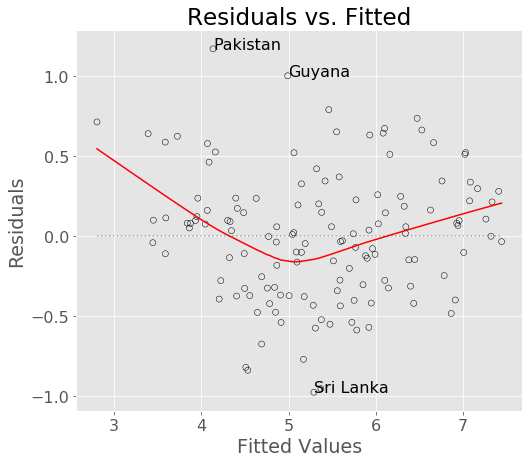

In [63]:
from statsmodels.nonparametric.smoothers_lowess import lowess
residuals = mlr_model.resid
fitted = mlr_model.fittedvalues
smoothed = lowess(residuals, fitted)
top3 = abs(residuals).sort_values(ascending=False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8, 7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors='k', facecolors='none')
ax.plot(smoothed[:, 0], smoothed[:, 1], color='r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted), max(fitted)], [0, 0], color='k', linestyle=':', alpha=.3)

for i in top3.index:
    ax.annotate(i, xy=(fitted[i], residuals[i]))

plt.show()

The there is a slight curvy pattern in the plot, implying there is probably some non-linear structure.

**homoscedasticity**:

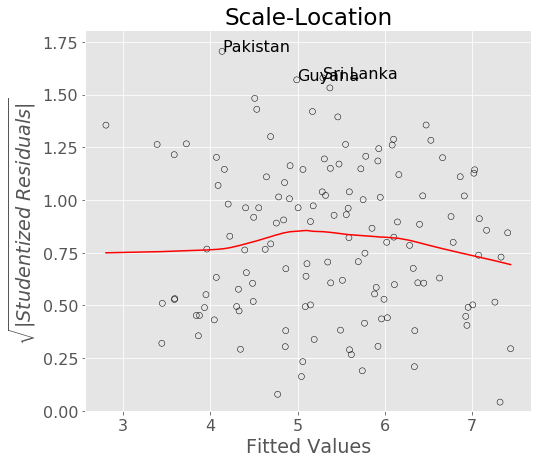

In [64]:
student_residuals = mlr_model.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = mlr_model.resid.index
smoothed = lowess(sqrt_student_residuals, fitted)
top3 = abs(sqrt_student_residuals).sort_values(ascending=False)[:3]

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors='k', facecolors='none')
ax.plot(smoothed[:, 0], smoothed[:, 1], color='r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0, max(sqrt_student_residuals)+0.1)
for i in top3.index:
    ax.annotate(i, xy=(fitted[i], sqrt_student_residuals[i]))
plt.show()

It shows a near perfect haphazard and no fanning pattern is displayed, so the homoscedasticity assumption is met.

**normally distributed residuals:**

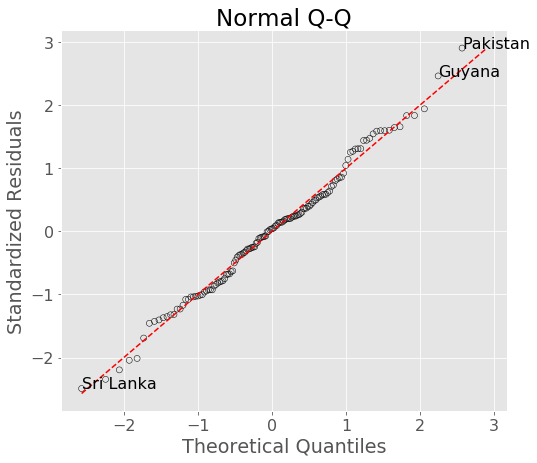

In [65]:
sorted_student_residuals = pd.Series(
    mlr_model.get_influence().resid_studentized_internal)
sorted_student_residuals.index = mlr_model.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending=True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(
    df['sorted_student_residuals'], dist='norm', fit=False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending=False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x, y, edgecolor='k', facecolor='none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x, y]), np.max([x, y])], [
        np.min([x, y]), np.max([x, y])], color='r', ls='--')
for val in top3.index:
    ax.annotate(val, xy=(df['theoretical_quantiles'].loc[val],
                         df['sorted_student_residuals'].loc[val]))
plt.show()

The residuals fits the line nearly perfect, hence we know the residuals are normally distributed.

Finally, we want to know if there are influential outliers (with Coooks' distance over 1) affecting our model, and there is none:

In [66]:
np.any(mlr_model.get_influence().cooks_distance[0] > 1)

False

## TASK 4: PRESENTATION

### Introduction
The World Happiness score a subjective score ranged 0-10. For each country, this score reflects "how happy their citizens perceive themselves to be." (WHR 2020) More importantly, this annual survey tries to find relationship between subjective happiness and other indicators of a country, so that it provides information for decision makers around the world what to improve to gain their country's happiness.

The official report focuses on six features: GDP per capita, expected health life, social support, freedom to make life choice, perception of government and business corruption, and ethical generosity. A broader version of the model also includes the idea of positive/negative affect, which measures the positive/negative experience the surveyed person has recently. The official report uses various data sources, mainly from Gallop.

Here we tries to build our own model, which is based on two data sources: WHR summary data, and external World Bank indicators.

### Process
The WHR data is provided, but World Bank indicators need to be acquired by World Bank indicator API. World Bank gives us access a wide range of indicators that describe a country's social, economical, environmental status, etc.

We select the following five numeric indicators:
- Population
- Urban Population Percentage
- Unemployment Rate
- Government Expenditure on Education against GDP (from Education category)
- Forest Area Percentage

After we retrieve the data via World Bank indicator API, we did some wrangling work to make sure the two data sources using inconsistent country/region names are well integrated together.

We then consciously drop some features in our data that we consider not meaningful to our model's context, as well as the data that do not pass our quality threshold. We have also verified the uniqueness of our data records. In short, we have prepared our data for model building in the next step. The prepared data is appended as a csv file for your reference.

For model building, we have built a multiple linear regression model using double direction stepwise variable selection.

Lastly, we evaluated our model to be relatively effective and reliable.

### Conclusion
The model we get is:
> Life Ladder = -2.01 + 0.21 * Log GDP Per Capita + 2.15 * Positive Affect + 0.04 * Healthy Life Expectancy + 0.1 * Government Expenditure on Education against GDP + 0.01 * Urban Population Percentage + 1.47 * Social Support + 0.56 * Generosity - 0.47 * Perception of Corruption

Compared to the official WHR model, there are a few feature differences: our model excludes freedom of choice and adds in urban population percentage, and government expenditure on education against GDP. Multicollinearity might explains the difference.

To summarize, a country's happiness score is positively related to: GDP per capita, feeling of social support, expected health life, being generous, positive mental affect, urban population percentage, and government expenditure on education. It's also negatively related to the perception of the country's corruption situation.